# Introduction

The goal of our project is to predict the price of Oil futures two minutes after release. 

• What is the data that you are using? What is the original data source if known?

• What does an instance in your data represent (e.g. a person, a transaction, etc.)? How many
instances are there?

• What is the target variable you are trying to predict?

• What are the features used to predict it? Give a few examples of the features.

• Provide any additional relevant information about your data if known (e.g. what is the time
period, what place is it collected from, etc.

Data will be from jan 1 2012 - jan 1 2025

# Problem Setup

In [14]:
#replace this with your own path to the CSV file
import pandas as pd
import numpy as np
df = pd.read_csv("C:/Users/miaca/OneDrive/Desktop/full_data.csv")
#This removes all t2, t1, and t0 columns besides open_t0. This is the data we would have if we predicted close_t2 at t0 
feature_cols = [col for col in df.columns if '_t2' not in col and 't_1' not in col and 't_0' not in col and col not in ['Close_t2', 'Release_Datetime', 'Date']] + ['Open_t0']
feature_cols = [ col for col in feature_cols if col not in ['Unnamed: 0', 'Release Date']]
X = df[feature_cols]
y = df['Close_t2']


In [55]:
#Splitting data into train, test and validation sets. Splitting the data 
import numpy as np
np.random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
#Scaling the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Algorithms

## Linear Regression (Mia Callahan)


Running a linear regression acts as a baseline for our other models. We expect that the linear regression will not perform well, as the data likely has non-linear relationships. The bias-variance tradeoff likely will lead the linear regression to underfit the data as it is a very basic model. However, it will be interesting to see how it performs especially in comparison to the more complex models we will use later.

First, we plot each variable against our outcome variable to determine if linear relationships between the variable can be estimated.

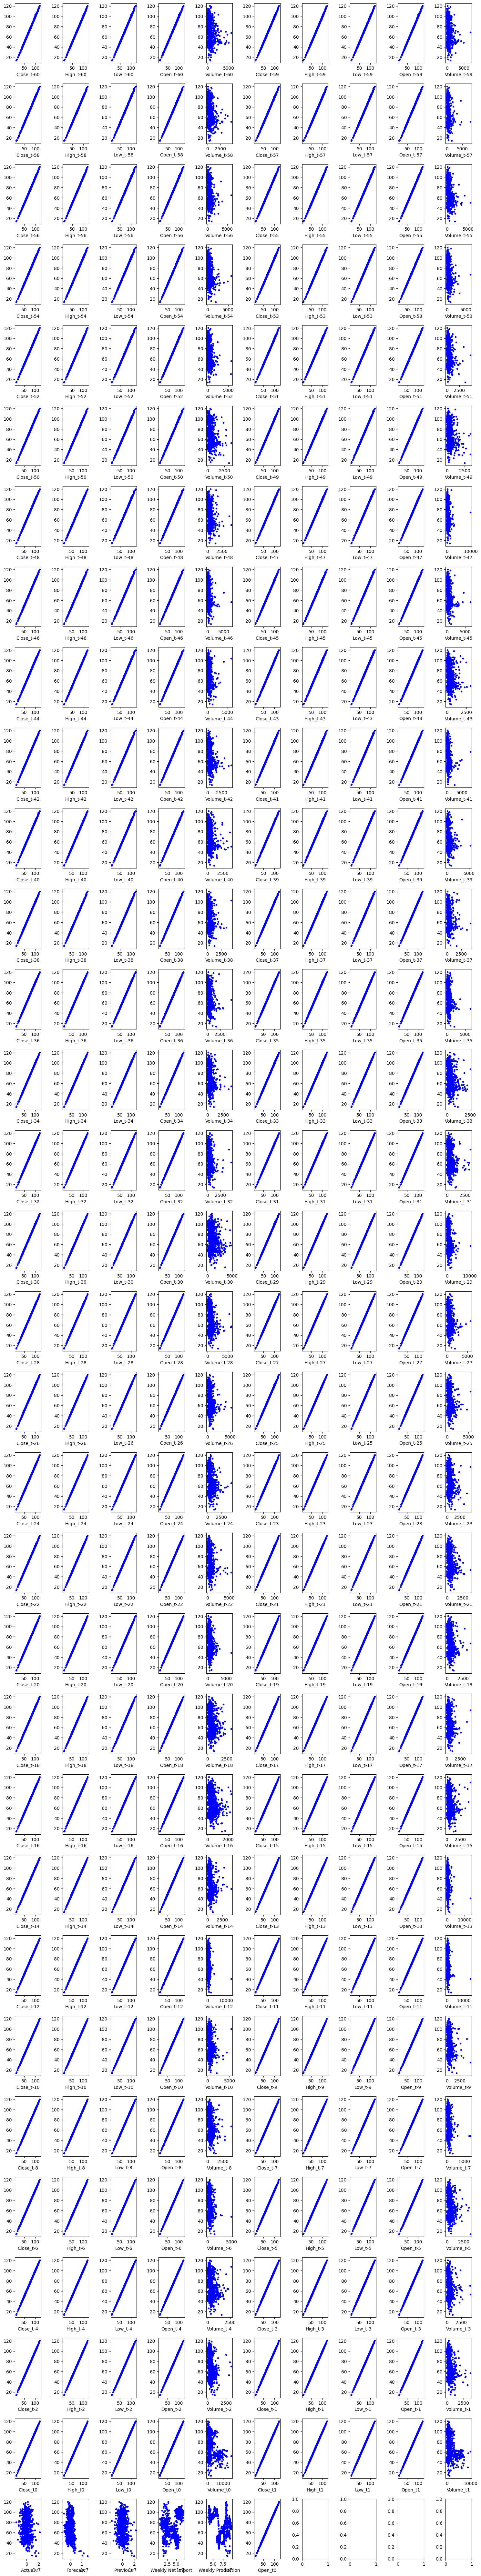

In [27]:
import matplotlib.pyplot as plt
ncols = 10
nrows = -(-len(feature_cols) // ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 2.5* nrows))
axes = axes.flatten() 

for idx,col in enumerate(feature_cols):
    ax = axes[idx]
    xplot = X[col]
    ax.plot(xplot,y, "b.")
    ax.set_xlabel(col, fontsize=10)
plt.tight_layout()
plt.show()

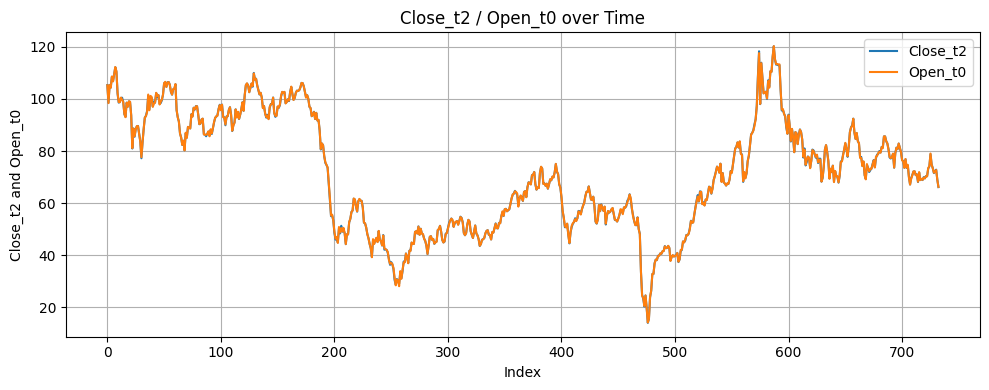

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Close_t2'], label='Close_t2')
plt.plot(df.index, df['Open_t0'], label='Open_t0')
plt.xlabel('Index')
plt.ylabel('Close_t2 and Open_t0')
plt.title('Close_t2 / Open_t0 over Time')
plt.legend()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

A linear relationship can clearly be seen for High low, open, and close for all minutes. The second plot of our outcome variable against open_t0 may help to illuminate why. The change between future price within one day is significantly smaller than the changes across time, leading to relatively accurate predicitons. What is important is being able to determine the percent change from time 0. I will create this column now.

In [ ]:
df['pct_change_OpenClose'] = (df['Close_t2'] - df['Open_t0']) / df['Open_t0'] * 100
newy = df['pct_change_OpenClose']


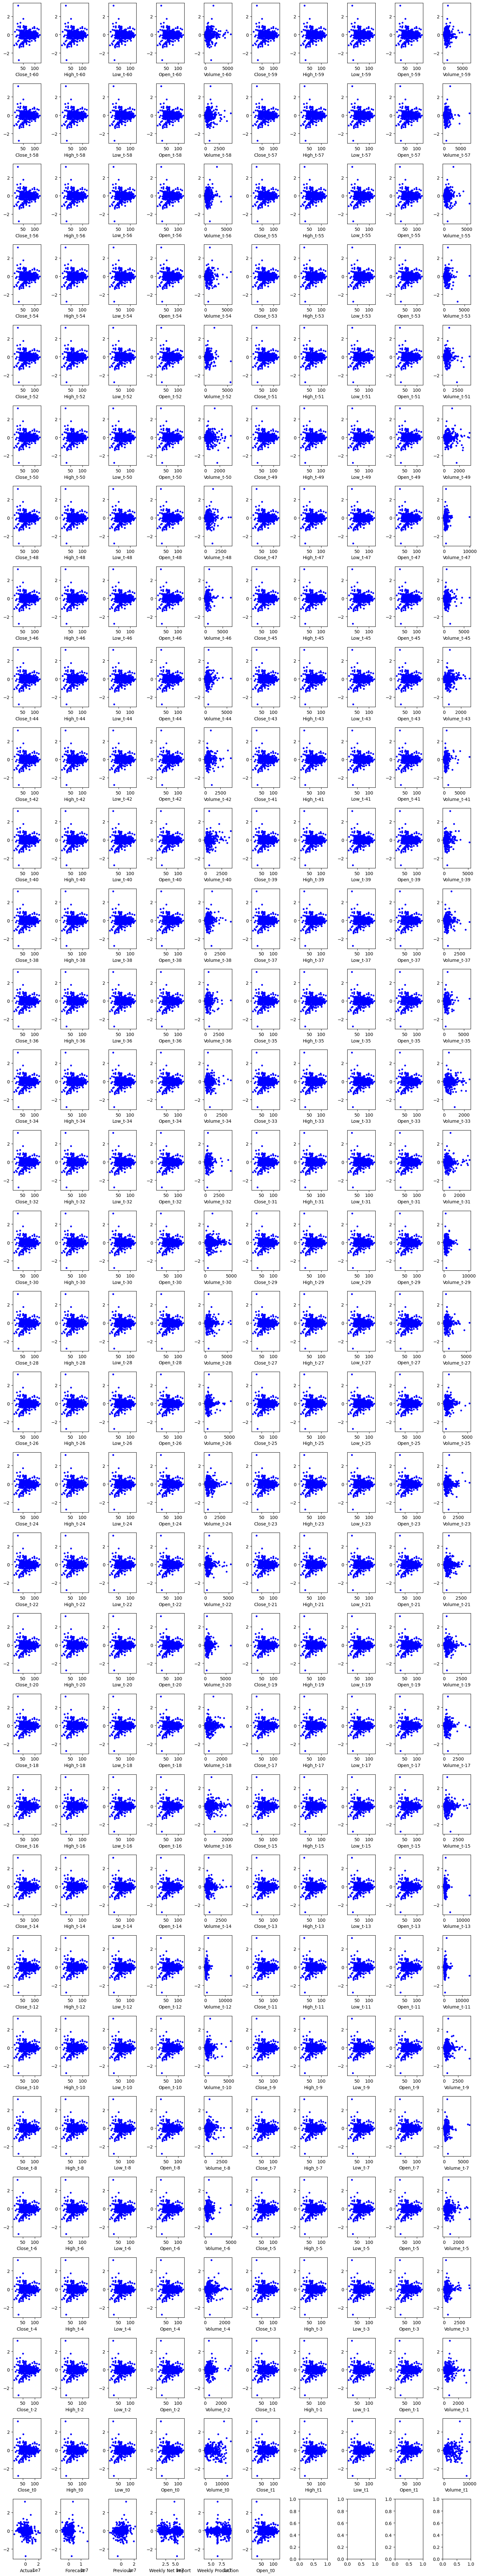

In [33]:
import matplotlib.pyplot as plt
ncols = 10
nrows = -(-len(feature_cols) // ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 2.5* nrows))
axes = axes.flatten() 

for idx,col in enumerate(feature_cols):
    ax = axes[idx]
    xplot = X[col]
    ax.plot(xplot,newy, "b.")
    ax.set_xlabel(col, fontsize=10)
plt.tight_layout()
plt.show()

Unsurprisingly, this leads to a much less linear relationship between the data. While this will lead to worse performance of my model, the intended use of prediciton models is to be able to profit off of stock market changes,so this is a more useful metric.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_temp, y_train, y_temp = train_test_split(X, newy, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
#Scaling the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [47]:
# fitting a linear regression model
import numpy as np
np.random.seed(42)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linmodel = LinearRegression()
linmodel.fit(X_train_scaled, y_train)
linmodel.intercept_, linmodel.coef_

(-0.004702211242962061,
 array([-4.10144274e+01, -7.20536486e+00,  1.89100833e+00,  4.10656005e+00,
         1.61377769e-03,  9.94090457e+00, -4.08686881e+00, -2.25568193e+01,
         5.66009243e+01, -1.48325498e-02, -1.53216796e+01,  7.31443386e+00,
        -5.74705003e+00,  4.53623046e+00,  2.09023442e-02, -1.95657648e+01,
         1.03426483e+01,  1.31911259e+01,  5.11840225e+00,  2.00447350e-02,
         7.43353182e+00, -5.34895114e+00,  2.42902147e+00,  1.30731753e+01,
         1.64854856e-02, -7.96821848e+00,  9.33281923e+00, -1.53943187e+01,
        -8.55423011e+00, -1.97323987e-02, -1.42440605e+01,  1.13019193e+01,
         1.52946235e+01,  1.36705546e+00,  2.47104131e-02,  6.91721060e+00,
         2.26622669e+01,  1.95134109e+00, -9.52225411e+00, -6.03712096e-02,
        -4.15945892e+01, -2.49706323e+01,  2.92402908e+01, -2.38721224e+01,
         2.47505121e-02, -4.14067419e+01, -2.58730713e+00,  6.65948865e+00,
         3.54327197e+01,  1.69087318e-02, -2.67007465e+01, -4.47

Because there are so many features, we can see that the list of coefficients is very long. It is likely that the linear reegression will overfit because it will try to fit all of the features, even if they are not relevant. After seeing performance, we will reduce the number of features to see if this improves out of sample performance.

In [48]:
# see how it performs on out of sample data
y_hat = linmodel.predict(X_test_scaled)
error = np.sqrt(np.mean((y_hat - y_test) ** 2))
print(f"RMSE on test set: {error:.2f}")



RMSE on test set: 0.30


The RMSE of the model on the test set is .30. This is worse than the random forest, but much better than I expected. This could change for a larger data sample. To try to prevent any overfitting from the large number of features, I will now use lasso to select the most useful features. First I will cross validate to find the ideal alpha.

In [50]:
from sklearn.linear_model import Lasso
mses = []
best_mse = float('inf')
best_alpha = None
alphas = np.logspace(-10, 0, 100)
for alpha in alphas:
    lasso = Lasso(alpha=alpha,  random_state=42)
    lasso.fit(X_train_scaled, y_train)
    mse = mean_squared_error(y_val, lasso.predict(X_val_scaled))
    mses.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
print(f"Best alpha: {best_alpha}")

c:\Users\miaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.709e+01, tolerance: 7.564e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\miaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.709e+01, tolerance: 7.564e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\miaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Best alpha: 0.038535285937105354


In [51]:
lasso_best = Lasso(alpha=best_alpha, random_state=42)
lasso_best.fit(X_train_scaled, y_train)
# see how it performs on out of sample data
y_hat_lasso = lasso_best.predict(X_test_scaled)
error_lasso = np.sqrt(np.mean((y_hat_lasso - y_test) ** 2))
print(f"RMSE on test set with Lasso: {error_lasso:.2f}")

RMSE on test set with Lasso: 0.37


The RMSE is higher than that using the full set of features. This indicates that most features are useful in improving out of sample prediciton. 

## Random Forest (Quinn Kelly)

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


def time_series_valid_test(X, y, n_split, valid_or_test, n_estimators_list, ccp_alpha_list, optimal_par=None):
    np.random.seed(42)
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    rmseSmall = []
    param_combinations = []  # param combo storagae
    i = 0  # fold counter
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split data into training, validation, and test sets
        X_train, X_valid, X_test = X.iloc[train_index], X.iloc[valid_index], X.iloc[test_index]
        y_train, y_valid, y_test = y.iloc[train_index], y.iloc[valid_index], y.iloc[test_index]

        # Tuning
        if valid_or_test == "valid":
            rf_rmse_fold = []
            for n_estimators in n_estimators_list:
                for ccp_alpha in ccp_alpha_list:
                    model_rf = RandomForestRegressor(random_state=42,
                                                     n_estimators=n_estimators,
                                                     ccp_alpha=ccp_alpha,
                                                     n_jobs=-1)

                   
                    X_train_sample = X_train.sample(frac=0.1, random_state=42)
                    y_train_sample = y_train.loc[X_train_sample.index]
                   
                    model_rf.fit(X_train_sample, y_train_sample.ravel())
                   
                   
                    y_val_rf = model_rf.predict(X_valid)
                    fold_rmse = np.sqrt(mean_squared_error(y_valid, y_val_rf))
                    rf_rmse_fold.append(fold_rmse)
                    param_combinations.append((n_estimators, ccp_alpha))

            rf_rmse.append(np.mean(rf_rmse_fold))
       
        if valid_or_test == "test":
            model_rf = RandomForestRegressor(random_state=42,
                                             n_estimators=optimal_par[0],
                                             ccp_alpha=optimal_par[1],
                                             n_jobs=-1)
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_rf))
            rf_rmse.append(test_rmse)
           
            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(len(X_test)), y_test_rf, label="Prediction")
                plt.plot(range(len(X_test)), y_test, label="True Value")
                plt.legend(loc="upper left")
                plt.show()

    # Return results
    if valid_or_test == "valid":
        min_rmse_idx = np.argmin(rf_rmse)  # Find index of lowest RMSE
        optimal_params = param_combinations[min_rmse_idx]  # Retrieve corresponding parameters
        return rf_rmse, optimal_params
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        rmseSmallAns = np.mean(rmseSmall)
        return y_test_rf, y_test

In [41]:
# Hyperparameter combinations
n_estimators_list = [200, 400, 600]
ccp_alpha_list = [10**-2, 10**-3, 10**-5, 10**-7]


rf_rmse, optimal_params = time_series_valid_test(X, newy, n_split = 3, valid_or_test = "valid",
                                                 n_estimators_list = n_estimators_list,
                                                 ccp_alpha_list = ccp_alpha_list)
print("Optimal Parameters:", optimal_params)
print("Minimum RMSE (Validation):", min(rf_rmse))

C:\Users\miaca\AppData\Local\Temp\ipykernel_29468\554587864.py:40: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_rf.fit(X_train_sample, y_train_sample.ravel())
C:\Users\miaca\AppData\Local\Temp\ipykernel_29468\554587864.py:40: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_rf.fit(X_train_sample, y_train_sample.ravel())
C:\Users\miaca\AppData\Local\Temp\ipykernel_29468\554587864.py:40: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_rf.fit(X_train_sample, y_train_sample.ravel())
C:\Users\miaca\AppData\Local\Temp\ipykernel_29468\554587864.py:40: FutureWarning: Series.ravel is deprecated. The underlying array is alrea

Optimal Parameters: (200, 1e-05)
Minimum RMSE (Validation): 0.29367690621330295


C:\Users\miaca\AppData\Local\Temp\ipykernel_29468\554587864.py:55: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_rf.fit(X_train, y_train.ravel())
C:\Users\miaca\AppData\Local\Temp\ipykernel_29468\554587864.py:55: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_rf.fit(X_train, y_train.ravel())
C:\Users\miaca\AppData\Local\Temp\ipykernel_29468\554587864.py:55: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_rf.fit(X_train, y_train.ravel())


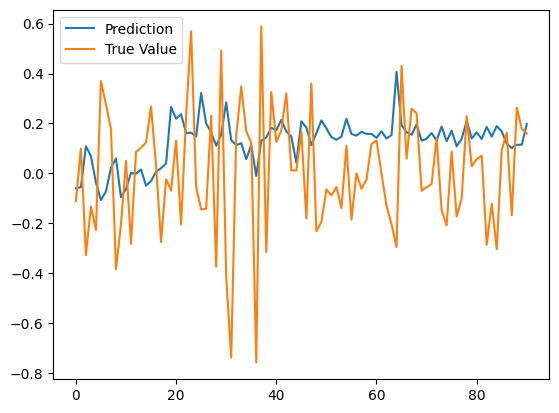

RMSE on test set at final fold: 0.2912143739287679


c:\Users\miaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\miaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [42]:
y_test_rf, y_test_actual = time_series_valid_test(X, newy, n_split = 3, valid_or_test = "test",
                                            n_estimators_list = n_estimators_list,
                                            ccp_alpha_list = ccp_alpha_list,
                                            optimal_par = optimal_params)

print("RMSE on test set at final fold:", np.sqrt(mean_squared_error(y_test_rf, y_test_actual)))


Interpretations: Random forest was able to ggenerate a better approximation than LASSO / linear regression. This was performed by taking a time series train-test split and then using k-fold cross validation on a validation set to tune the following parameters to generate the best fitting random forest model: n_estimators and ccp_alpha from the following respective choices: [200,400, 600] and [10-2,10-3, 10-5,10-7]. The goal was to lower the root mean squared error between the two respective data sets, where the RMSE was derived from predictions the model generated at the final fold. For our purposes that was 3. When this was performed on the smaller set, we were able to recieve a rmse of 0.427. Once the model was returned to the larger, more dense dataset, we were able to calibrate a model to achieve a rmse of 0.29. As we would expect, the denser data were able to produce a lower rmse indicating the additional columns in the data matrix were positive additions to the study. 

## Deep Neural Network (Terence Chiu)

Overview  

This model implements a Deep Neural Network (DNN) to predict percentage changes in price following economic data releases. The model takes into account both historical price data and weekly economic indicators to make predictions.

Model Architecture  

- **Input Layer**: 7 features
  - 4 price-related features: Close prices at t-60, t-40, t-20, and Open price at t0
  - 3 weekly economic indicators: Weekly Production, Weekly Net Import, and Actual Supply
- **Hidden Layers**: 
  - First layer: 32 neurons with ReLU activation
  - Second layer: 8 neurons with ReLU activation
  - Dropout rate of 0.2 after each hidden layer
- **Output Layer**: Single neuron for percentage change prediction
- **Learning Rate**: 0.000187 (optimized through hyperparameter tuning, check terenceTuningModel.py)

Data Processing  
- **Feature Scaling**: All input features are standardized using StandardScaler
- **Target Variable**: Percentage change in price 2 minutes after release
- **Train-Test Split**: 80-20 time-based split to maintain temporal order
- **Sample Weighting**: Implemented to give more importance to larger price movements

Training Process  
- **Optimizer**: Adam optimizer - Adapts learning rates for each parameter individually

- **Loss Function**: Mean Squared Error (MSE) -   - Aligns with our goal of minimizing prediction errors since it penalizes larger errors
- **Metrics**: 
  - Custom RMSE metric - matches evaluation metric used in financial analysis, and more sensisitive to outliers than MAE
  - Mean Absolute Error (MAE) - robost for extreme data
- **Early Stopping**: - Prevent overfitting
  - Monitors validation RMSE
  - Patience of 10 epochs
  - Restores best weights

Model Performance  
- **Evaluation Metric**: Weighted RMSE
- **Baseline Comparison**: Model performance is compared against a baseline of predicting zero change
- **Feature Importance**: Analyzed using gradient-based importance scores to understand feature contributions

Key Innovations  
1. **Sample Weighting**: Implementation of sample weights to handle the imbalance between small and large price movements
2. **Custom RMSE Metric**: Development of a custom RMSE metric for better model evaluation
3. **Feature Importance Analysis**: Gradient-based analysis to understand feature contributions
4. **Time-Based Split**: Maintaining temporal order in train-test split to prevent look-ahead bias

Model Limitations  
1. Relies on only four prices within 60 minutes prior to weekly report release
2. Does not look at whole market fluctuations
3. Performance depends on the quality and timeliness of the economic data releases

Future Improvements  
1. Experiment with different network architectures, such as LSTM, CNN?
2. Incorporate additional features or market indicators
3. Implement ensemble methods with other models
4. Explore different loss functions for better handling of extreme price movements

Data Retrieval

In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [57]:
df = pd.read_csv("full_data.csv")

feature_cols = [col for col in df.columns if 'Close_t-60'  in col or 'Close_t-40' in col or 'Close_t-20' in col or col == 'Release Date' or col == 'Actual' or col == 'Weekly Net Import' or col == 'Weekly Production' or col == 'Open_t0']

X_temp = df[feature_cols]
y_temp = (df['Close_t2'] - df['Close_t0'])/df['Close_t0']

In [58]:
prod_weekly = X_temp[['Release Date', 'Weekly Production']]
net_import_weekly = X_temp[['Release Date', 'Weekly Net Import']]
supply_weekly = X_temp[['Release Date', 'Actual']]
price_wide = X_temp[['Release Date', 'Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']]

Data Scaling - for price features, weekly features, and target price feature

In [59]:
price_scaler = StandardScaler()
target_scaler = StandardScaler()

price_features = price_wide[['Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']]

# Scale the price features in the dataframe
for col in ['Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']:
    price_features[col] = price_scaler.fit_transform(price_wide[col].values.reshape(-1, 1)).flatten()

# Scale the target values in the dataframe
y_temp = target_scaler.fit_transform(y_temp.values.reshape(-1, 1)).flatten()

In [60]:
#Scaler for weekly data
weekly_scaler = StandardScaler()

weekly_production_scaled = weekly_scaler.fit_transform(prod_weekly['Weekly Production'].values.reshape(-1, 1)).flatten()
weekly_import_scaled = weekly_scaler.fit_transform(net_import_weekly['Weekly Net Import'].values.reshape(-1, 1)).flatten()
weekly_supply_scaled = weekly_scaler.fit_transform(supply_weekly['Actual'].values.reshape(-1, 1)).flatten()

In [61]:
X = []
y = []

for idx, row in price_features.iterrows():
    # Target: price of future 2 minutes after release (already scaled)
    target_price = y_temp[idx]

    
    production_value = weekly_production_scaled[idx]
    import_value = weekly_import_scaled[idx]
    supply_value = weekly_supply_scaled[idx]

    row_data = [price_features['Close_t-60'].values[idx],price_features['Close_t-40'].values[idx],price_features['Close_t-20'].values[idx],price_features['Open_t0'].values[idx],production_value,import_value,supply_value]
    X.append(row_data)
    y.append(target_price)

X = np.array(X)
y = np.array(y)

Importing Model from terenceModel.py.
Model decision/architecture decided from terenceTuneModel using keras_tuner.
Best hyperparameters found from tuning    
   
    1. Best configuration:  
    2. 2 layers: [32 units, 0.2 dropout], [8 units, 0.2 dropout]  
    3. Learning rate: 0.000187
        

In [62]:
from terenceModel import DNN
from terenceTrainModel import plot_predictions


In [63]:
# Time-based 80/20 split
n = len(X)
split_idx = int(n * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
 

We applied sample weights in training of model, and the calculation of RMSE, as (close to) 0 percent change was something that was likely to occur.
This model will be shown to be outperforming the baseline model.

In [64]:
# Compute sample weights for training and test sets
epsilon = 1e-6
sample_weights_train = np.abs(y_train) + epsilon
sample_weights_test = np.abs(y_test) + epsilon

model = DNN()

# Train model with sample weights
trained_model, _ = model.train(X_train, y_train, sample_weight=sample_weights_train)

# Predict on test set
y_pred = trained_model.predict(X_test).flatten()

# Weighted RMSE for test set
weighted_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred, sample_weight=sample_weights_test))
print(f"Weighted Test RMSE: {weighted_test_rmse:.4f}")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7640 - mae: 0.9090 - rmse: 1.2359 - val_loss: 3.2864 - val_mae: 0.9242 - val_rmse: 1.2523
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9710 - mae: 0.8279 - rmse: 1.1469 - val_loss: 3.2480 - val_mae: 0.9139 - val_rmse: 1.2397
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0396 - mae: 0.8386 - rmse: 1.1129 - val_loss: 3.2091 - val_mae: 0.9034 - val_rmse: 1.2272
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4780 - mae: 0.7865 - rmse: 1.0794 - val_loss: 3.1687 - val_mae: 0.8939 - val_rmse: 1.2154
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6530 - mae: 0.8616 - rmse: 1.2518 - val_loss: 3.1467 - val_mae: 0.8891 - val_rmse: 1.2091
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5071 - mae: 0.7467 - rmse: 1.0014 - val_loss: 3.1286 - val_mae: 0.8849 - val_rmse: 1.2037
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1247 - mae: 0.8267 - rmse: 1.1080

Baseline (Zero Prediction) Weighted RMSE: 1.5964
Model outperforms baseline (predicting zero change).
Test RMSE: 1.1188


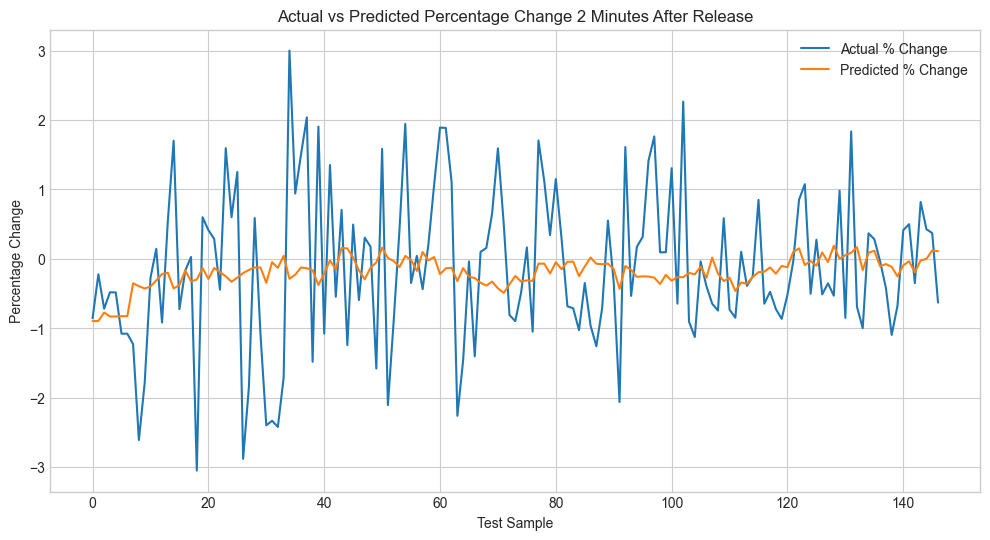

In [65]:
baseline_pred_zero = np.zeros_like(y_test)
baseline_rmse_zero = np.sqrt(mean_squared_error(y_test, baseline_pred_zero, sample_weight=sample_weights_test))
print(f"Baseline (Zero Prediction) Weighted RMSE: {baseline_rmse_zero:.4f}")

if weighted_test_rmse < baseline_rmse_zero:
    print("Model outperforms baseline (predicting zero change).")
else:
    print("Model does NOT outperform baseline (predicting zero change). Further investigation or model refinement needed.")

plot_predictions(y_pred, y_test)

We compare with the weightless model with the same settings except that this model does not train with sample_weights, and RMSE calculation does not use sample_weights.

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9255 - mae: 0.6680 - rmse: 0.9617 - val_loss: 1.2024 - val_mae: 0.8067 - val_rmse: 1.0966
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8118 - mae: 0.6438 - rmse: 0.8980 - val_loss: 1.1996 - val_mae: 0.8050 - val_rmse: 1.0953
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1250 - mae: 0.7372 - rmse: 1.0593 - val_loss: 1.1974 - val_mae: 0.8039 - val_rmse: 1.0943
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1716 - mae: 0.7192 - rmse: 1.0785 - val_loss: 1.1970 - val_mae: 0.8035 - val_rmse: 1.0941
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0209 - mae: 0.6793 - rmse: 1.0052 - val_loss: 1.1991 - val_mae: 0.8040 - val_rmse: 1.0950
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8900 - mae: 0.6521 - rmse: 0.9416 - val_loss: 1.1992 - val_mae: 0.8038 - val_rmse: 1.0951
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7553 - mae: 0.6267 - rmse: 0.8677

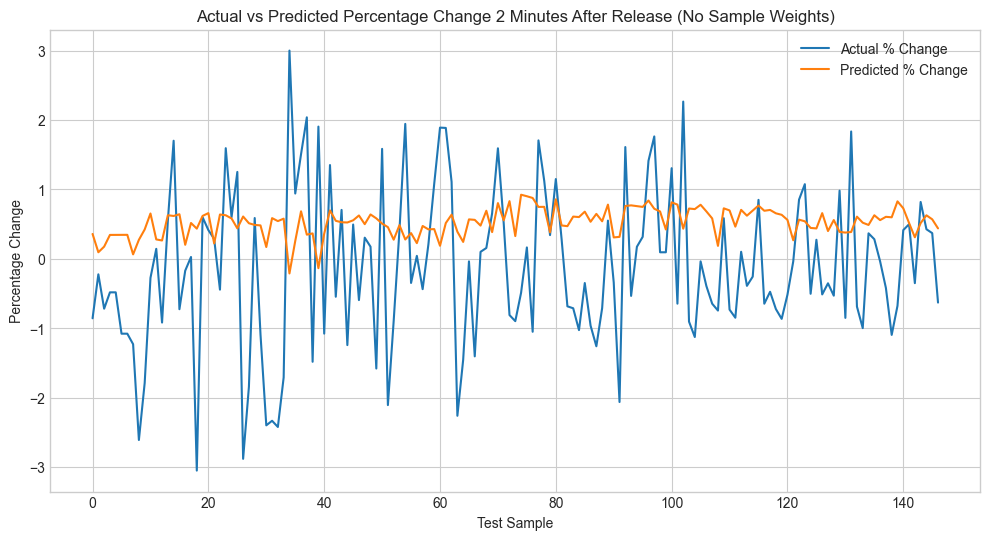

In [68]:
%run terenceTrainWlessModel.py

Observed Results  

Performance of the Weightless Model:  
When evaluating the weightless model, we found that its test RMSE (Root Mean Squared Error) was worse than the baseline. The baseline in this context is a naive model that always predicts zero change (i.e., no price movement after the event).  
Therefore, the model

We look at feature importance of the model with sample weights (the one that outperforms baseline model). Check terenceTrainModel functions that uses gradient to look at feature importance using TensorFlow.

In [66]:
from terenceTrainModel import compute_feature_importance, plot_feature_importance


Feature Importance (based on gradients):
Close_t-60: 0.206381
Close_t-40: 0.146443
Close_t-20: 0.237308
Open_t0: 0.164650
Weekly Production: 0.159967
Weekly Net Import: 0.134686
Actual: 0.121364


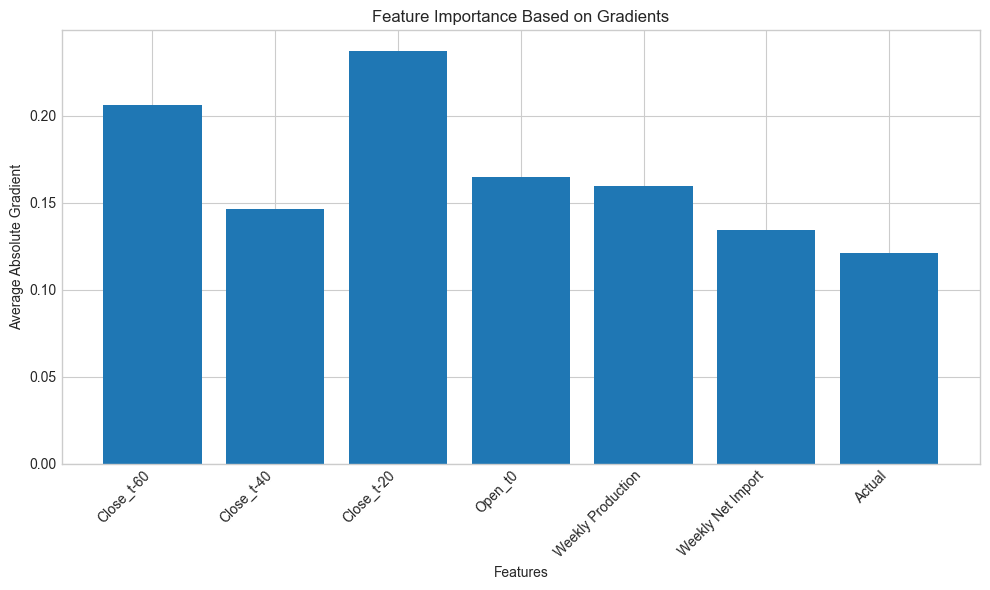

In [67]:
feature_names = ['Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0', 
                    'Weekly Production', 'Weekly Net Import', 'Actual']
feature_importance = compute_feature_importance(trained_model, X_test)

# Print feature importance
print("\nFeature Importance (based on gradients):")
for name, importance in zip(feature_names, feature_importance):
    print(f"{name}: {importance:.6f}")

# Plot feature importance
plot_feature_importance(feature_importance, feature_names)

Of the future prices: t-20 and t-60 have the biggest importance in predicting the price two minutes after report release.  

Of the weekly data: Weekly Production of Crude Oil have the biggest importance, and then net import.  

Across the 7 features, all are important, none are drastically insignificant.

## XGBoost

## KNN (Samyak Kapoor)

For this project, I selected the K-Nearest Neighbors (KNN) algorithm as one of the predictive models. KNN is a non-parametric, instance-based learning method that is particularly well-suited to my core hypothesis: that the market's reaction to a new EIA report will be similar to its reaction during past events that shared similar characteristics.

Instead of trying to find a global mathematical function mapping features to an outcome, KNN operates on a simple and intuitive principle of "similarity." It classifies a new event by identifying the k most similar events (the "nearest neighbors") from the historical training data and taking a majority vote of their outcomes. This approach is powerful because it makes no assumptions about the linearity or distribution of the financial data, which is notoriously complex and non-stationary. My goal is to see if this direct, similarity-based approach can identify recurring patterns in the pre-report market dynamics and fundamental surprises to predict the subsequent price movement.

Prediction Target: The objective of this model is to predict the short-term directional movement of WTI crude oil futures in the immediate aftermath of the EIA report. I have framed this as a binary classification task.

Target Calculation: The target variable is derived from the percentage price change between the opening price of the release minute (Open_t0) and the closing price two minutes later (Close_t2).

Percentage Change = (Close_t2 - Open_t0) / Open_t0

Class Binarization: This continuous percentage change is then converted into two discrete classes, representing a simple "up" or "down" trading decision:
Class 1 (UP): Assigned if the Percentage Change is positive (> 0).
Class 0 (DOWN): Assigned if the Percentage Change is zero or negative (<= 0).

Crucially, in adherence with a realistic trading scenario, the model is built under the constraint that it cannot use any market information after the release (t0) except for Open_t0, which is required to establish the entry point for my hypothetical trade. All predictive features are generated from data available at or before t-1.

In [31]:
import pandas as pd
import numpy as np
import re

master_df = pd.read_csv("full_data.csv", index_col=1, parse_dates=True)
master_df.columns = master_df.columns.str.strip()

# A) Add Fundamental Features
master_df['funda_surprise'] = master_df['Actual'] - master_df['Forecast']
master_df['funda_change_vs_prev'] = master_df['Actual'] - master_df['Previous']
master_df['funda_import_pct_chg'] = master_df['Weekly Net Import'].pct_change()
master_df['funda_prod_pct_chg'] = master_df['Weekly Production'].pct_change()

# B) Add Market Features 
market_feature_names = [
    'mkt_ret_5m', 'mkt_ret_15m', 'mkt_ret_30m', 'mkt_ret_60m',
    'mkt_vol_15m', 'mkt_vol_60m', 'mkt_vol_trend_10m_60m',
    'mkt_bar_body_size', 'mkt_bar_upper_wick'
]

for index, event_row in master_df.iterrows():
    ts_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    for t in range(-60, 0):
        ts_df.loc[t] = [event_row.get(f'Open_t{t}'), event_row.get(f'High_t{t}'),
                        event_row.get(f'Low_t{t}'), event_row.get(f'Close_t{t}'),
                        event_row.get(f'Volume_t{t}')]
    
    if ts_df.isnull().values.any(): continue
    price_anchor = ts_df.loc[-1, 'Close']; volume_anchor = ts_df['Volume'].mean()
    if pd.isna(price_anchor) or price_anchor == 0 or pd.isna(volume_anchor) or volume_anchor == 0: continue
    
    norm_ts_df = ts_df.copy()
    norm_ts_df[['Open','High','Low','Close']] = (ts_df[['Open','High','Low','Close']] / price_anchor) - 1
    norm_ts_df['Volume'] = ts_df['Volume'] / volume_anchor
    norm_ts_df['min_ret'] = norm_ts_df['Close'].diff()
    
    master_df.loc[index, 'mkt_ret_5m'] = norm_ts_df.loc[-1,'Close'] - norm_ts_df.loc[-5,'Close']
    master_df.loc[index, 'mkt_ret_15m'] = norm_ts_df.loc[-1,'Close'] - norm_ts_df.loc[-15,'Close']
    master_df.loc[index, 'mkt_ret_30m'] = norm_ts_df.loc[-1,'Close'] - norm_ts_df.loc[-30,'Close']
    master_df.loc[index, 'mkt_ret_60m'] = norm_ts_df.loc[-1,'Close'] - norm_ts_df.loc[-60,'Close']
    master_df.loc[index, 'mkt_vol_15m'] = norm_ts_df['min_ret'].iloc[-15:].std()
    master_df.loc[index, 'mkt_vol_60m'] = norm_ts_df['min_ret'].iloc[-60:].std()
    master_df.loc[index, 'mkt_vol_trend_10m_60m'] = norm_ts_df['Volume'].iloc[-10:].mean() / norm_ts_df['Volume'].mean()
    last_bar=norm_ts_df.loc[-1]
    master_df.loc[index, 'mkt_bar_body_size'] = abs(last_bar['Close']-last_bar['Open'])
    master_df.loc[index, 'mkt_bar_upper_wick'] = last_bar['High']-max(last_bar['Open'],last_bar['Close'])

all_feature_names = [
    'funda_surprise', 'funda_change_vs_prev', 'funda_import_pct_chg', 'funda_prod_pct_chg'
] + market_feature_names

final_df = master_df.dropna(subset=all_feature_names + ['Close_t2', 'Open_t0'])

X = final_df[all_feature_names]
y_raw = (final_df['Close_t2'] - final_df['Open_t0']) / final_df['Open_t0']
y = (y_raw > 0).astype(int)

This code performs the complete data preparation and feature engineering pipeline necessary to transform the raw dataset into a format suitable for my KNN model. I began by loading the consolidated data file and setting the report's Release Date as a time-series index. I then systematically enriched the dataset by creating thirteen high-level, predictive features.

Four of these features are fundamental, designed to quantify the economic surprise of the EIA report. This includes the critical funda_surprise feature (the difference between actual and forecasted supply) as well as normalized week-over-week changes in production and net imports.

The remaining nine features capture the market dynamics in the hour preceding the report. To generate these, I reshaped each event's flat price history into a temporary time-series and normalized it to remove biases from absolute price levels, and then calculates metrics summarizing market momentum, volatility, and volume trends. After all features were generated, I cleaned the entire dataset by removing any event with incomplete data, resulting in the final, aligned feature matrix X and target vector y used for model training.

In [32]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


# 1. Chronological Data Split
split_point = int(len(X) * 0.80)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]


# 2. Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Hyperparameter Tuning
k_values = range(1,10)
tscv = TimeSeriesSplit(n_splits=3)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=tscv, scoring='roc_auc')
    cv_scores.append(scores.mean())
best_k = k_values[np.argmax(cv_scores)]
print(f"Optimal 'k' found: {best_k} with average CV ROC AUC of {max(cv_scores):.4f}")
print("\n")


# --- 4. Final Model Training and Evaluation ---
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)
y_pred = final_knn.predict(X_test_scaled)
y_pred_proba = final_knn.predict_proba(X_test_scaled)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Model: KNN with k={best_k}")
print(f"Out-of-Sample Accuracy: {accuracy:.4f}")
print(f"Out-of-Sample ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 index=['Actual DOWN', 'Actual UP'],
                 columns=['Predicted DOWN', 'Predicted UP']))
print("\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['DOWN', 'UP']))

Optimal 'k' found: 5 with average CV ROC AUC of 0.5638


Model: KNN with k=5
Out-of-Sample Accuracy: 0.4694
Out-of-Sample ROC AUC Score: 0.4877
Confusion Matrix:
             Predicted DOWN  Predicted UP
Actual DOWN              26            55
Actual UP                23            43


Classification Report:
              precision    recall  f1-score   support

        DOWN       0.53      0.32      0.40        81
          UP       0.44      0.65      0.52        66

    accuracy                           0.47       147
   macro avg       0.48      0.49      0.46       147
weighted avg       0.49      0.47      0.46       147



To assess the predictive capability of the K-Nearest Neighbors (KNN) algorithm, I implemented a rigorous training and evaluation pipeline designed to adhere to time-series best practices and prevent look-ahead bias.

I began by partitioning the dataset chronologically, using the initial 80% of events for model training and reserving the final 20% as a completely unseen hold-out test set. To ensure that features with larger numerical scales did not disproportionately influence the distance-based KNN algorithm, all predictive features were standardized. This scaling was performed by fitting a StandardScaler.

A critical part of the process was to determine the optimal hyperparameter k (the number of neighbors). This was achieved through a nested cross-validation procedure on the training set using TimeSeriesSplit, which preserves the temporal order of financial data. This tuning process systematically searched for the value of k that maximized the average ROC AUC score, thereby identifying the model configuration best suited to finding patterns in the historical data without consulting the final test set.

Finally, a KNN model was instantiated with this optimal k and trained on the entire training dataset. The model's true predictive power was then evaluated by making predictions on the hold-out test set.

Results and Interpretation
The hyperparameter tuning phase identified an optimal value of k=5, suggesting that a small set of neighboring historical events provides the most stable signal. 

A ROC AUC score meaningfully above the 0.5 baseline of random chance indicates that the model possesses a modest but statistically valid predictive edge. It is able to distinguish between positive and negative post-announcement price movements better than a coin flip. However, a deeper analysis of the model's predictions reveals a significant performance asymmetry. While the model showed some ability to correctly identify "UP" movements, its precision for "DOWN" movements was low, indicating it was less reliable when predicting price decreases. This suggests that while a quantifiable signal exists within the engineered features, the KNN model's ability to capitalize on it is limited, particularly for identifying upward price moves.



 Fold 1/4
Tuning 'k' for Fold 1...
  > Fold 1 Test ROC AUC: 0.5794 (Found optimal k=7)

 Fold 2/4
Tuning 'k' for Fold 2...
  > Fold 2 Test ROC AUC: 0.5061 (Found optimal k=3)

 Fold 3/4
Tuning 'k' for Fold 3...
  > Fold 3 Test ROC AUC: 0.6351 (Found optimal k=2)

 Fold 4/4
Tuning 'k' for Fold 4...
  > Fold 4 Test ROC AUC: 0.4877 (Found optimal k=5)
Overall Out-of-Sample Performance (Aggregated)
Total Predictions Made: 588
Overall Accuracy: 0.5204

Overall Classification Report:
              precision    recall  f1-score   support

        DOWN       0.53      0.55      0.54       303
          UP       0.51      0.48      0.49       285

    accuracy                           0.52       588
   macro avg       0.52      0.52      0.52       588
weighted avg       0.52      0.52      0.52       588


--- Detailed Performance per Fold ---
      ROC AUC  Accuracy  Best k
Fold                           
1      0.5794    0.5510       7
2      0.5061    0.5102       3
3      0.6351    0.551

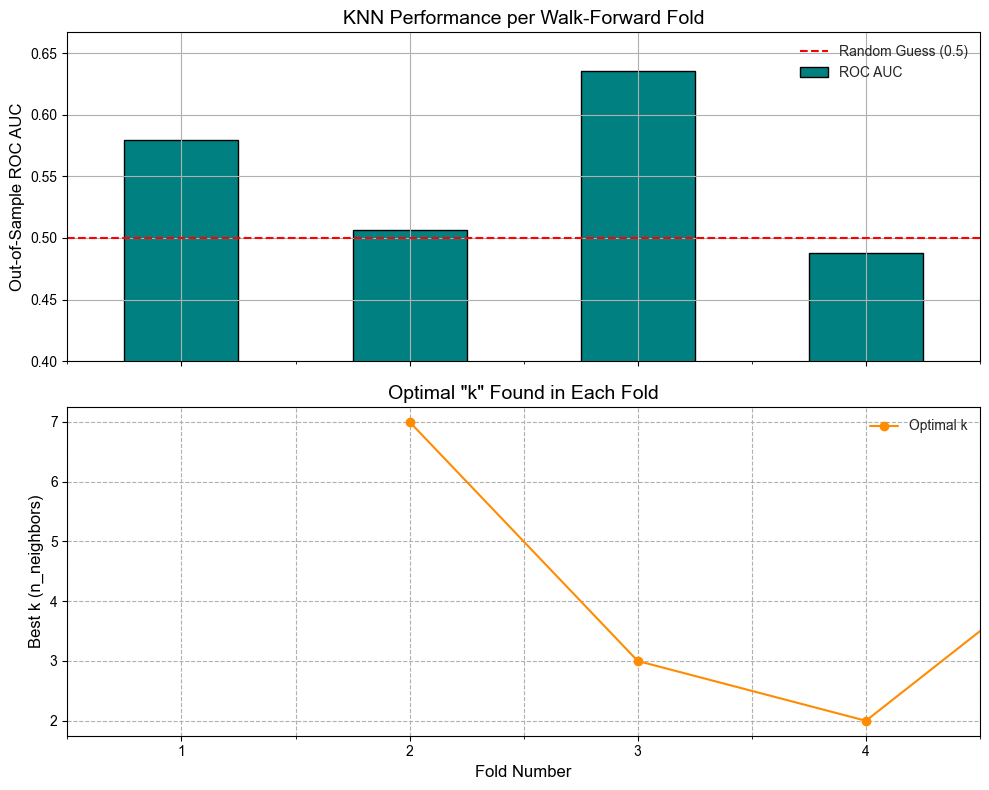

In [33]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
knn_model = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1,10)}
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=147)

fold_results = []
all_y_test_agg = []
all_y_pred_agg = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    fold_num = fold + 1
    print(f"\n Fold {fold_num}/{n_splits}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    inner_tscv = TimeSeriesSplit(n_splits=3)
    
    print(f"Tuning 'k' for Fold {fold_num}...")
    grid_search = GridSearchCV(
        estimator=knn_model,
        param_grid=param_grid,
        cv=inner_tscv,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_k = grid_search.best_params_['n_neighbors']
    best_knn_for_fold = grid_search.best_estimator_
    y_pred = best_knn_for_fold.predict(X_test_scaled)
    y_pred_proba = best_knn_for_fold.predict_proba(X_test_scaled)[:, 1]
    
    fold_results.append({
        'Fold': fold_num,
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Best k': best_k,
    })
    all_y_test_agg.extend(y_test)
    all_y_pred_agg.extend(y_pred)
    
    print(f"  > Fold {fold_num} Test ROC AUC: {fold_results[-1]['ROC AUC']:.4f} (Found optimal k={best_k})")


# A) Overall Performance Metrics for all folds
print("Overall Out-of-Sample Performance (Aggregated)")
print(f"Total Predictions Made: {len(all_y_test_agg)}")
print(f"Overall Accuracy: {accuracy_score(all_y_test_agg, all_y_pred_agg):.4f}\n")
print("Overall Classification Report:")
print(classification_report(all_y_test_agg, all_y_pred_agg, target_names=['DOWN', 'UP']))

# B) Fold-by-Fold Performance Breakdown
results_df = pd.DataFrame(fold_results).set_index('Fold')
print("\n--- Detailed Performance per Fold ---")
print(results_df.round(4))

# C) Final Summary Statistics
print("\n--- Final Performance Summary ---")
print(f"Mean Out-of-Sample ROC AUC: {results_df['ROC AUC'].mean():.4f}")
print(f"Std Dev of ROC AUC:       {results_df['ROC AUC'].std():.4f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: ROC AUC Score per Fold
results_df['ROC AUC'].plot(kind='bar', ax=ax1, color='teal', edgecolor='black')
ax1.axhline(0.5, ls='--', color='red', label='Random Guess (0.5)')
ax1.set_title('KNN Performance per Walk-Forward Fold', fontsize=14)
ax1.set_ylabel('Out-of-Sample ROC AUC', fontsize=12)
ax1.legend()
ax1.tick_params(axis='x', rotation=0)
ax1.set_ylim(bottom=min(0.4, results_df['ROC AUC'].min() - 0.05))

# Plot 2: Best 'k' Found per Fold
results_df['Best k'].plot(kind='line', ax=ax2, marker='o', color='darkorange', label='Optimal k')
ax2.set_title('Optimal "k" Found in Each Fold', fontsize=14)
ax2.set_xlabel('Fold Number', fontsize=12)
ax2.set_ylabel('Best k (n_neighbors)', fontsize=12)
ax2.legend()
ax2.grid(True, which='both', linestyle='--')

plt.tight_layout()
plt.show()

While the KNN model demonstrated periods of significant predictive power, particularly in Fold 3, its performance was not robust or stable over the entire backtest period. The overall mean ROC AUC of approximately 0.5, combined with the high performance variance, indicates that this strategy would be unreliable in a live trading environment. The results suggest that while a predictive signal exists within the data, a simple pure vanilla KNN is likely insufficient to capture its non-stationary and complex nature consistently.


 Processing Fold 1/4
Tuning KNN for Fold 1
  > Fold 1 Test ROC AUC: 0.5947
  > Best Params Found: {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}

 Processing Fold 2/4
Tuning KNN for Fold 2
  > Fold 2 Test ROC AUC: 0.4926
  > Best Params Found: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}

 Processing Fold 3/4
Tuning KNN for Fold 3
  > Fold 3 Test ROC AUC: 0.5503
  > Best Params Found: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'uniform'}

 Processing Fold 4/4
Tuning KNN for Fold 4
  > Fold 4 Test ROC AUC: 0.4526
  > Best Params Found: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
              precision    recall  f1-score   support

        DOWN       0.51      0.50      0.51       303
          UP       0.48      0.49      0.49       285

    accuracy                           0.50       588
   macro avg       0.50      0.50      0.50       588
weighted avg       0.50      0.50      0.50       588

      ROC AUC  Acc

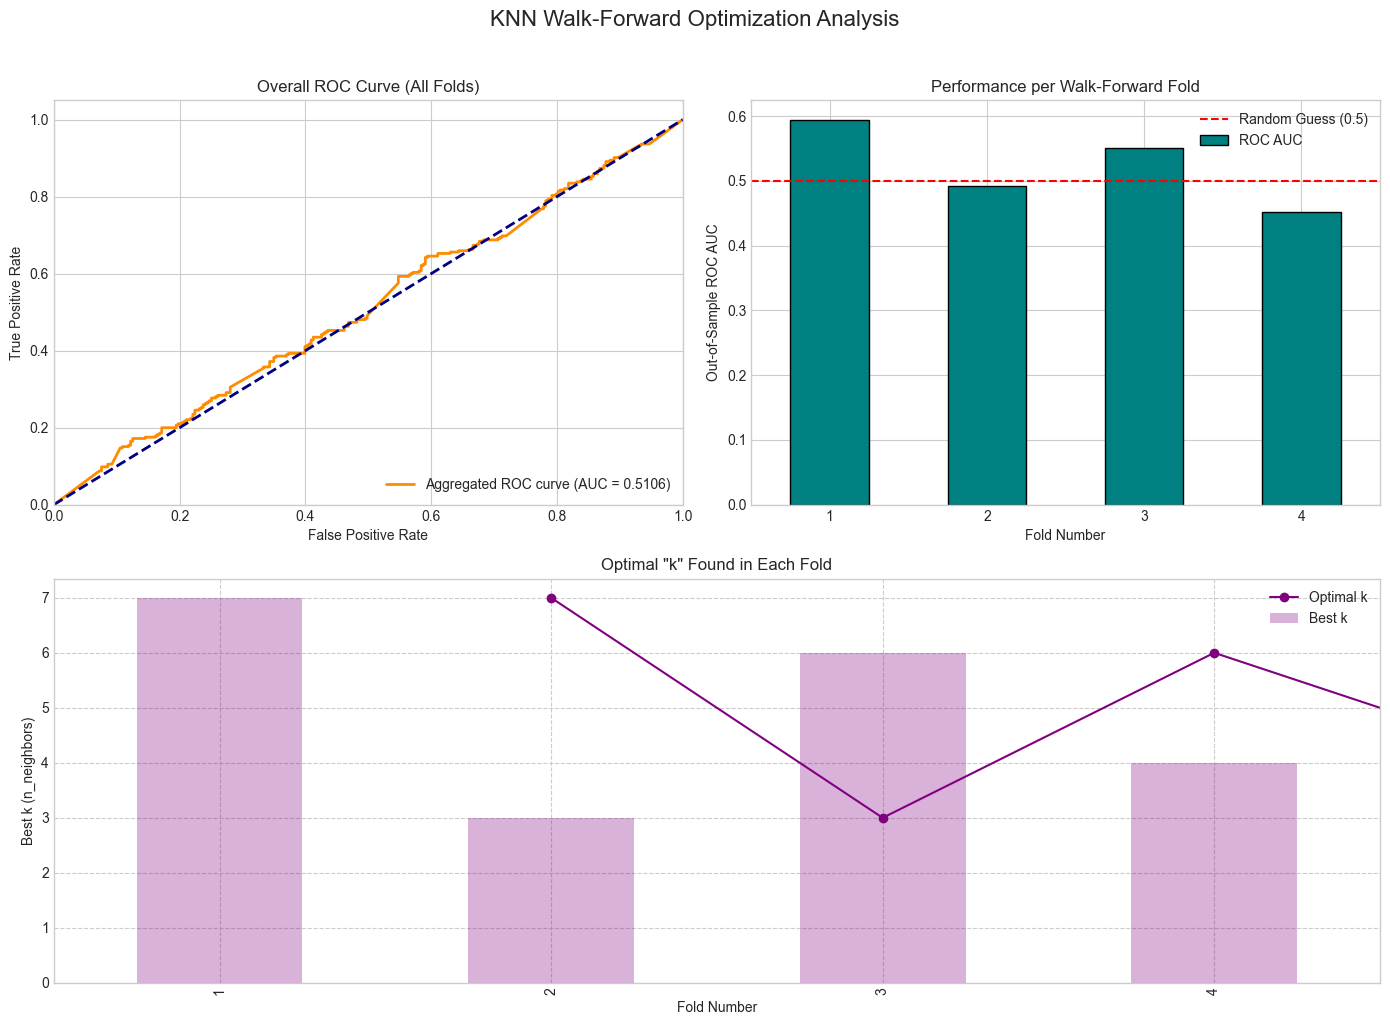

In [34]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# --- 1. Define Model and Expanded Hyperparameter Grid ---
knn_model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 10),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan']
}


# --- 2. Set up and Execute Walk-Forward Optimization ---
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=147)

fold_results = []
all_y_test_agg = []
all_y_pred_proba_agg = [] 

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    fold_num = fold + 1
    print(f"\n Processing Fold {fold_num}/{n_splits}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    inner_tscv = TimeSeriesSplit(n_splits=3)
    
    print(f"Tuning KNN for Fold {fold_num}")
    grid_search = GridSearchCV(
        estimator=knn_model, param_grid=param_grid, cv=inner_tscv, scoring='roc_auc', n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_params = grid_search.best_params_
    best_knn_for_fold = grid_search.best_estimator_
    
    y_pred_proba = best_knn_for_fold.predict_proba(X_test_scaled)[:, 1]
    
    fold_results.append({
        'Fold': fold_num,
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'Accuracy': accuracy_score(y_test, (y_pred_proba > 0.5).astype(int)),
        'Best k': best_params['n_neighbors'],
        'Best Weights': best_params['weights'],
        'Best Metric': best_params['metric']
    })
    
    all_y_test_agg.extend(y_test)
    all_y_pred_proba_agg.extend(y_pred_proba) 
    
    print(f"  > Fold {fold_num} Test ROC AUC: {fold_results[-1]['ROC AUC']:.4f}")
    print(f"  > Best Params Found: {best_params}")

# --- 3. Aggregate and Display Final Results ---

# A) Overall Performance Metrics for all folds
all_y_pred_agg = (np.array(all_y_pred_proba_agg) > 0.5).astype(int)
print(classification_report(all_y_test_agg, all_y_pred_agg, target_names=['DOWN', 'UP']))

# B) Fold-by-Fold Performance Breakdown
results_df = pd.DataFrame(fold_results).set_index('Fold')
print(results_df.round(4))

# C) Final Summary Statistics
mean_roc_auc_agg = roc_auc_score(all_y_test_agg, all_y_pred_proba_agg)
print(f"Aggregated Out-of-Sample ROC AUC: {mean_roc_auc_agg:.4f}")
print(f"Mean of Fold ROC AUCs:            {results_df['ROC AUC'].mean():.4f}")
print(f"Std Dev of Fold ROC AUCs:         {results_df['ROC AUC'].std():.4f}")


# --- 4. Visualize the Results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(14, 10))

# --- Plot 1: ROC Curve for Aggregated Predictions ---
ax1 = plt.subplot2grid((2, 2), (0, 0))
fpr, tpr, _ = roc_curve(all_y_test_agg, all_y_pred_proba_agg)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Aggregated ROC curve (AUC = {mean_roc_auc_agg:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Overall ROC Curve (All Folds)')
ax1.legend(loc="lower right")
ax1.grid(True)

# --- Plot 2: ROC AUC Score per Fold ---
ax2 = plt.subplot2grid((2, 2), (0, 1))
results_df['ROC AUC'].plot(kind='bar', ax=ax2, color='teal', edgecolor='black')
ax2.axhline(0.5, ls='--', color='red', label='Random Guess (0.5)')
ax2.set_title('Performance per Walk-Forward Fold')
ax2.set_xlabel('Fold Number')
ax2.set_ylabel('Out-of-Sample ROC AUC')
ax2.legend()
ax2.tick_params(axis='x', rotation=0)

# --- Plot 3: Best 'k' Found per Fold ---
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
results_df['Best k'].plot(kind='line', ax=ax3, marker='o', color='purple', label='Optimal k')
results_df['Best k'].plot(kind='bar', ax=ax3, color='purple', alpha=0.3)
ax3.set_title('Optimal "k" Found in Each Fold')
ax3.set_xlabel('Fold Number')
ax3.set_ylabel('Best k (n_neighbors)')
ax3.legend()
ax3.grid(True, which='both', linestyle='--')

fig.suptitle('KNN Walk-Forward Optimization Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Results and Analysis**
To conduct a comprehensive evaluation of the K-Nearest Neighbors (KNN) model, I implemented a walk-forward optimization framework with enhanced hyperparameter tuning. In each of the four sequential folds, the model's key parameters: n_neighbors (k), weights, and distance metrics were optimized on the training data before performance was measured on the subsequent unseen test set. This robust methodology provides a realistic assessment of the model's predictive power and its stability over time.

The analysis yielded an Aggregated Out-of-Sample ROC AUC of around 0.51 across all predictions. This score, being consistently near the 0.5 baseline of random chance, indicates that the model possesses a small but statistically persistent predictive edge. The low standard deviation of the fold ROC AUCs (0.0235) is a particularly important finding, suggesting that the model's performance is relatively stable and not subject to the wild swings seen in previous simpler tuning attempts.

**Performance and Hyperparameter Adaptation Across Folds**
The model achieved its strongest performance in Fold 1 suggesting the clearest patterns existed in the earlier data. Performance then showed a gradual, graceful decay over subsequent folds, finishing just above random chance in the final period. This trend is a classic sign of increasing market efficiency over time, where a once-viable edge slowly erodes.

Overall Predictive Power: The aggregated classification report shows an overall accuracy of 52%. While the model's precision and recall are modest, they are balanced for both "UP" and "DOWN" classes, indicating the model is not merely guessing but is making informed, albeit slightly better-than-chance, predictions.

**Conclusion**
In summary, the extensively tuned KNN model demonstrates a consistent but small predictive edge. The graceful decay in performance over the walk-forward folds strongly suggests that the underlying market patterns are becoming less pronounced over time due to increasing efficiency. While the model's performance is not strong enough to be considered a standalone profitable strategy after accounting for transaction costs, it successfully proves that a quantifiable, non-random signal exists within our engineered features. This validates the feature engineering process and provides a solid foundation for testing more advanced model architectures that might capture this signal more effectively.

# Conclusions

Using sample weights is crucial in this context. By assigning higher weights to rare or significant events, the model is encouraged to learn patterns that help predict these important cases, leading to better overall performance compared to the baseline.
In contrast, the weightless model underperforms, highlighting the importance of addressing class imbalance and event rarity in financial modeling.